# Mangrove forest monitoring using deep learning

#### Compare imagery to calculate area change in mangrove forests.

## Table of Contents
* [Introduction](#Introduction)
* [Necessary imports](#Necessary-imports)
* [Get data and model for classification](#Get-data-and-model-for-classification)
* [Extract mangrove forests for 2014](#Extract-mangrove-forests-for-2014)
* [Extract mangrove forests for 2022](#Extract-mangrove-forests-for-2022)
* [Calculate change in area over time](#Calculate-change-in-area-over-time)
* [Conclusion](#Conclusion)
* [References](#References)

## Introduction 

Mangrove forests are one of the most productive and biologically important ecosystems of the world. Mangroves are distributed in the inter-tidal region between the sea and the land in the tropical and subtropical regions. Mangroves act as a natural barrier against natural hazards such as hurricanes, cyclones, tsunamis etc. The forests are plays an essential role in stopping coastal-erosion processes. Mangroves are also important for biodiversity and ecosystem management. It also plays an important role in carbon balance in the coastal areas.

The decline of mangroves is caused due to land cover changes over time i.e. conversion of mangrove areas into agriculture, aquaculture, built-ups and industrialization. A significant amount of the loss is caused by natural forces, such as tsunamis, cyclones, and there is threat of global warming.

The study area of this sample notebook is Mumbai. Studies shows that Mumbai lost nearly 40% of its mangrove forests between 1991 to 2001. In 2013 government made mangroves forests as reserved forests also appointed forest settlement officers and settlement of rights. Forest Survey reports shows that the mangrove cover has been increasing every year due to the conservation efforts.

Traditionally, mangroves were extracted using LULC maps or using band ratio techniques. Deep learning automates the process and minimizes the manual interaction necessary to complete these tasks. To quantify the change in mangrove forests surface area from 2014 to 2022, we'll extract the mangroves in both images using pretrained model, calculating changes in terms of area over the time.

This sample aims to demonstrate how ArcGIS pretrained models can be used to generate landcover from imageries of different time periods for further analysis. Once the land covers are created, we will use arcgis.raster submodule of ArcGIS API for Python for calculating surface area reduced from 2016 to 2017.

Note: This sample is supported with ArcGIS Image for ArcGIS Online. For more details read [here](https://www.esri.com/arcgis-blog/products/arcgis-online/imagery/introducing-arcgis-image-for-arcgis-online/).

## Necessary imports

In [2]:
import arcgis
from arcgis.gis import GIS
from arcgis.learn import classify_pixels
from arcgis.raster.functions import extract_band, colormap


import pandas as pd
from datetime import datetime as dt
from ipywidgets import HBox, VBox, Label, Layout

In [10]:
gis = GIS("home")

## Get data and model for classification

Search for  Multispectral Landsat 8 Collection 2 Level 2 imagery for year 2014 and 2022 on the [USGS Earth Explorer](https://earthexplorer.usgs.gov/).  Download imagery of the desired time period and publish them in ArcGIS Online. The code below uses the `get` method to access the items.

In [11]:
ras_2014 = gis.content.get("e98e43b537354130b6a706e597c37f05").layers[0]
ras_2022 = gis.content.get("19d8df11f062443286097a744cce1864").layers[0]

Search for the <b>Mangrove Classification (Landsat 8)</b> deep learning package in ArcGIS Online. We can search for content shared by users outside our organization by setting `outside_org` to True.

<Item title:"Mangrove Classification (Landsat 8)" type:Deep Learning Package owner:esri_analytics>
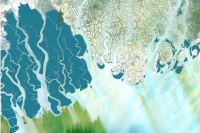

In [13]:
model = gis.content.search("Mangrove Classification (Landsat 8) owner: esri_analytics",
                           "Deep Learning Package",
                           outside_org=True)[0]
model

## Extract mangrove forests for 2014

To quantify the changes in area of mangrove forests from 2014 to 2022, we'll classify the mangrove forests in both images, calculate the area. In multispectral imagery, such as Landsat-8, every individual pixel (or cell) in the image has DN value for every spectral band, the pixels representing the same land cover tend to have somewhat similar spectral values which helps the model to identify mangroves also differentiate mangroves from other type of forests. 

In [14]:
# desired extent for processing
ext={'spatialReference': {'latestWkid': 3857, 'wkid': 102100},
 'xmin': 8078570.021208307,
 'ymin': 2132519.778887492,
 'xmax': 8153784.057040948,
 'ymax': 2193669.4015156566}

`classify_pixels` raster function will be used to extract the mangrove forests from the imagery using the pretrained model.

In [18]:
extracted_mangroves2014 = classify_pixels(input_raster=ras_2014,
                                          model=model,
                                          model_arguments={"padding": 64,
                                                           "batch_size": 32,
                                                           "predict_background": True,
                                                           "tile_size": 256,
                                                           "test_time_augmentation": True},
                                          output_name="extracted_mangroves_2014" + str(dt.now().microsecond),
                                          context={"extent": ext, "processorType": "GPU", "cellSize": 30},
                                          tiles_only=False)

In [19]:
mangroves2014 = colormap(extracted_mangroves2014.layers[0], colormap=[[1, 255, 255, 0]])

To create a false colour composite from Landsat-8 imagery `extract_band` raster function will be used. 

In [20]:
ras2014_fcc = extract_band(ras_2014, [5, 3, 2])

Two map widgets are created showing false colour composite and extracted mangroves for the year 2014.

In [21]:
map3 = gis.map()
map3.add_layer(ras2014_fcc)
map4 = gis.map()
map4.add_layer(ras2014_fcc)
map4.add_layer(mangroves2014)

All the maps are synchronized with each other using [MapView.sync_navigation](https://developers.arcgis.com//python/api-reference/arcgis.widgets.html#arcgis.widgets.MapView.sync_navigation) functionality. It vizualises the extracted mangroves and the FCC composite for reference. Detailed description about advanced map widget options can be referred [here](https://developers.arcgis.com//python/guide/advanced-map-widget-usage/).

In [22]:
map3.sync_navigation(map4)
map3.extent=ext

[Hbox and Vbox](https://developers.arcgis.com/python/api-reference/arcgis.widgets.html?highlight=hbox) were used to set the layout of map widgets.

In [38]:
hbox_layout = Layout()
hbox_layout.justify_content = "space-around"
hb1 = HBox([Label("Landsat Imagery, 2014"), Label("Extracted Mangrove Forest, 2014")])
hb1.layout = hbox_layout
VBox([hb1, HBox([map3, map4])])

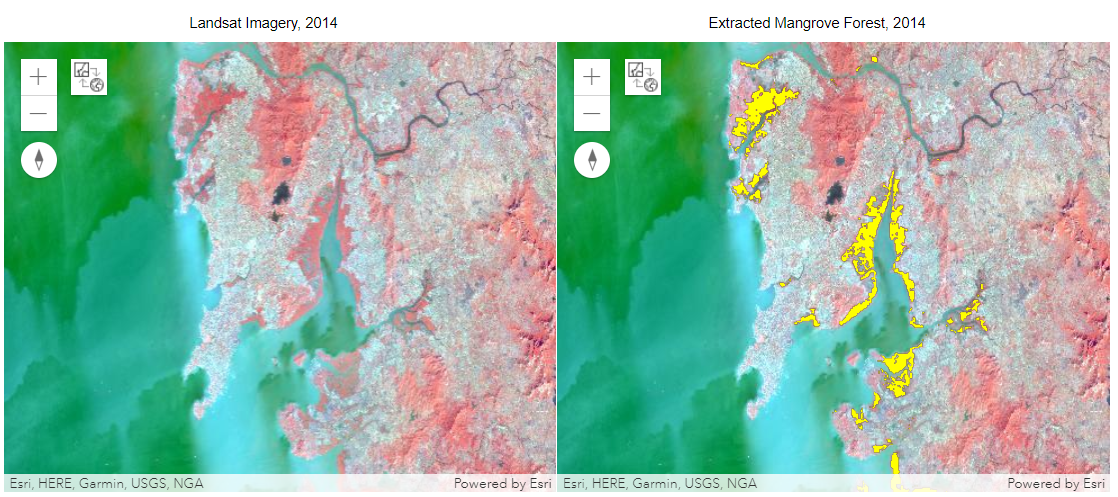

The pixel size of the raster is required to calculate the area covered by mangrove forest. We will use `<raster>.properties.pixelSizeX` and `<raster>.properties.pixelSizeY` functions to find the pixel size of the raster.

In [24]:
## Cellsize
ras2014_cellsize_x = extracted_mangroves2014.layers[0].properties.pixelSizeX
ras2014_cellsize_y = extracted_mangroves2014.layers[0].properties.pixelSizeY
print(ras2014_cellsize_x, ras2014_cellsize_y)

30 30


To calculate the area of land covered by mangrove forest, we will use `<raster>.attribute_table()` function to find the total pixel count for <b>Mangrove</b> class.

In [25]:
extracted_mangroves2014.layers[0].attribute_table()

{'objectIdFieldName': '',
 'fields': [{'name': 'OID',
   'type': 'esriFieldTypeOID',
   'alias': 'OID',
   'domain': None},
  {'name': 'Value',
   'type': 'esriFieldTypeInteger',
   'alias': 'Value',
   'domain': None},
  {'name': 'Class',
   'type': 'esriFieldTypeString',
   'alias': 'Class',
   'domain': None,
   'length': 254},
  {'name': 'Red',
   'type': 'esriFieldTypeInteger',
   'alias': 'Red',
   'domain': None},
  {'name': 'Green',
   'type': 'esriFieldTypeInteger',
   'alias': 'Green',
   'domain': None},
  {'name': 'Blue',
   'type': 'esriFieldTypeInteger',
   'alias': 'Blue',
   'domain': None},
  {'name': 'Count',
   'type': 'esriFieldTypeDouble',
   'alias': 'Count',
   'domain': None}],
 'features': [{'attributes': {'OID': 0,
    'Value': 1,
    'Class': 'Mangrove',
    'Red': 255,
    'Green': 255,
    'Blue': 0,
    'Count': 119036}}]}

This study requires the calculation of the area of land under mangrove forest in terms of square km. The raster uses the <b>UTM projected coordinate system (32643)</b>, the pixel unit is in meters.

In [26]:
## area in square kilometers
area_2014 = (119036*(ras2014_cellsize_x*ras2014_cellsize_y)/1000000)
area_2014

107.1324

## Extract mangrove forests for 2022

Next, we will follow the same process to extract the mangrove forest and calculate the total area covered by the mangroves for the year 2022. `classify_pixels` function will be used to extract the mangrove forests from the imagery using the pretrained model.

In [27]:
extracted_mangroves2022 = classify_pixels(input_raster=ras_2022,
                                          model=model,
                                          model_arguments={"padding": 64,
                                                           "batch_size": 32,
                                                           "predict_background": True,
                                                           "tile_size": 256,
                                                           "test_time_augmentation": True},
                                          output_name="extracted_mangroves_2022" + str(dt.now().microsecond),
                                          context={"extent": ext, "processorType": "GPU", "cellSize": 30},
                                          tiles_only=False)

In [28]:
mangroves2022 = colormap(extracted_mangroves2022.layers[0], colormap=[[1, 255, 255, 0]])

To create a false colour composite from Landsat-8 imagery `extract_band` raster function will be used. 

In [29]:
ras2022_fcc = extract_band(ras_2022, [5, 3, 2])

Two map widgets are created showing false colour composite and extracted mangroves for the year 2022.

In [30]:
map5 = gis.map()
map5.add_layer(ras2022_fcc)
map6 = gis.map()
map6.add_layer(ras2022_fcc)
map6.add_layer(mangroves2022)

All the maps are synchronized with each other using [MapView.sync_navigation](https://developers.arcgis.com//python/api-reference/arcgis.widgets.html#arcgis.widgets.MapView.sync_navigation) functionality. It vizualises the extracted mangroves and the FCC composite for reference. 

In [31]:
map5.sync_navigation(map6)
map5.extent=ext

[Hbox and Vbox](https://developers.arcgis.com/python/api-reference/arcgis.widgets.html?highlight=hbox) were used to set the layout of map widgets.

In [37]:
hbox_layout = Layout()
hbox_layout.justify_content = "space-around"
hb1 = HBox([Label("Landsat Imagery, 2022"), Label("Extracted Mangrove Forest, 2022")])
hb1.layout = hbox_layout
VBox([hb1, HBox([map5, map6])])

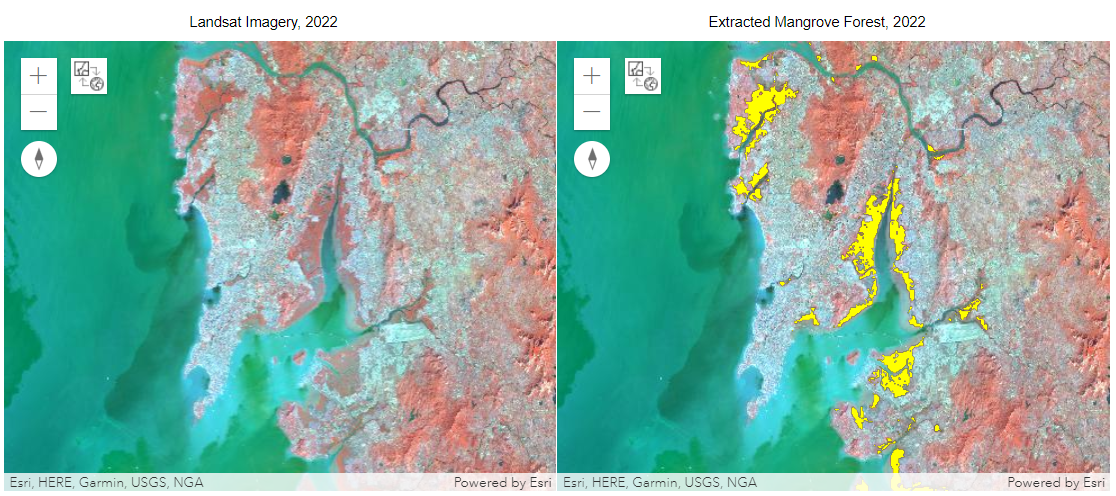

The pixel size of the raster is required to calculate the area covered by mangrove forest. We will use `<raster>.properties.pixelSizeX` and `<raster>.properties.pixelSizeY` functions to find the pixel size of the raster.

In [33]:
## Cellsize
ras2022_cellsize_x = extracted_mangroves2022.layers[0].properties.pixelSizeX
ras2022_cellsize_y = extracted_mangroves2022.layers[0].properties.pixelSizeY
print(ras2022_cellsize_x, ras2022_cellsize_y)

30 30


To calculate the area of land covered by mangrove forest, we will use `<raster>.attribute_table()` function to find the total pixel count for <b>Mangrove</b> class.

In [34]:
extracted_mangroves2022.layers[0].attribute_table()

{'objectIdFieldName': '',
 'fields': [{'name': 'OID',
   'type': 'esriFieldTypeOID',
   'alias': 'OID',
   'domain': None},
  {'name': 'Value',
   'type': 'esriFieldTypeInteger',
   'alias': 'Value',
   'domain': None},
  {'name': 'Class',
   'type': 'esriFieldTypeString',
   'alias': 'Class',
   'domain': None,
   'length': 254},
  {'name': 'Red',
   'type': 'esriFieldTypeInteger',
   'alias': 'Red',
   'domain': None},
  {'name': 'Green',
   'type': 'esriFieldTypeInteger',
   'alias': 'Green',
   'domain': None},
  {'name': 'Blue',
   'type': 'esriFieldTypeInteger',
   'alias': 'Blue',
   'domain': None},
  {'name': 'Count',
   'type': 'esriFieldTypeDouble',
   'alias': 'Count',
   'domain': None}],
 'features': [{'attributes': {'OID': 0,
    'Value': 1,
    'Class': 'Mangrove',
    'Red': 255,
    'Green': 255,
    'Blue': 0,
    'Count': 134872}}]}

This study requires the calculation of the area of land under mangrove forest in terms of square km. The raster uses the <b>UTM projected coordinate system (32643)</b>, the pixel unit is in meters.

In [35]:
area_2022 = (134872*(ras2022_cellsize_x*ras2022_cellsize_y)/1000000)
area_2022

121.3848

## Calculate change in area over time

Next step is to calculate the change in area in terms of square kilometer.

In [36]:
# area in square kilometers
area_gained = (area_2022 - area_2014)  
area_gained

14.252399999999994

The analysis shows that approximately 14 square kilometer area of mangrove forest has been increased from 2014 to 2022 which means the conservation related efforts by government, local bodies and NGOs were successful.

## Conclusion

In this sample, we extracted mangrove forests from Landsat-8 imagery for the year 2014 and 2022 to understand how much the mangrove forest area has changed over time. These findings indicates that the conservation efforts by governments and NGOs were able to protect the mangrove forests and also increase the area covered by the mangroves.

## References

- https://livingatlas.arcgis.com/en/browse/?q=dlpk#d=2&q=dlpk